# Physical data

## Importing libraries

In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import ruptures as rpt
import statsmodels.formula.api as smf
import scipy as sp
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

## Calculate distance-based metrics for player fitness

### Opening data

In [2]:
# Defining data that we need
DATADIR = 'D:\MetricaData\data'
game_id = 2

# Reading in the event data
events = mio.read_event_data(DATADIR, game_id)

# Reading in tracking data
tracking_home = mio.tracking_data(DATADIR, game_id, 'Home')
tracking_away = mio.tracking_data(DATADIR, game_id, 'Away')

# Converting positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# Reversing direction of play in the second half so that home team is always attacking from right->left
tracking_home, tracking_away, events = mio.to_single_playing_direction(tracking_home, tracking_away, events)

GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]
home_attack_direction = mio.find_playing_direction(tracking_home,'Home') # 1 if shooting left-right, else -1

Reading team: home
Reading team: away


### Calculating player velocities

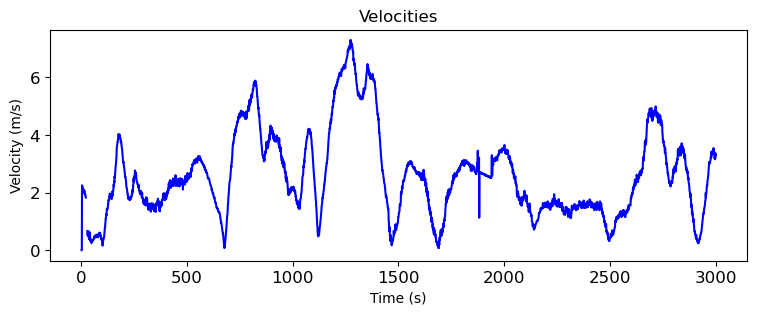

In [3]:
# Calculating the player Velocities
player_ids = np.unique(list(c[:-2] for c in tracking_home.columns if c[:4] in ['Home', 'Away']))
maxspeed = 12 #impossible to run faster than 12 m/s
dt = tracking_home['Time [s]'].diff()

# Getting first frame of second half
second_half_idx = tracking_home.Period.idxmax()

tracking_home = mvel.calc_player_velocities(tracking_home, smoothing=False)
tracking_away = mvel.calc_player_velocities(tracking_away, smoothing=False)

# Plotting data
plt.figure(figsize=(9, 3))

plt.plot(range(1, 3001), tracking_home.loc[1:3000]['Home_5_speed'], color = "blue")
plt.title('Velocities')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
vel = tracking_home.loc[1:9000]['Home_5_speed']
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

### Calculating total distance covered by team players

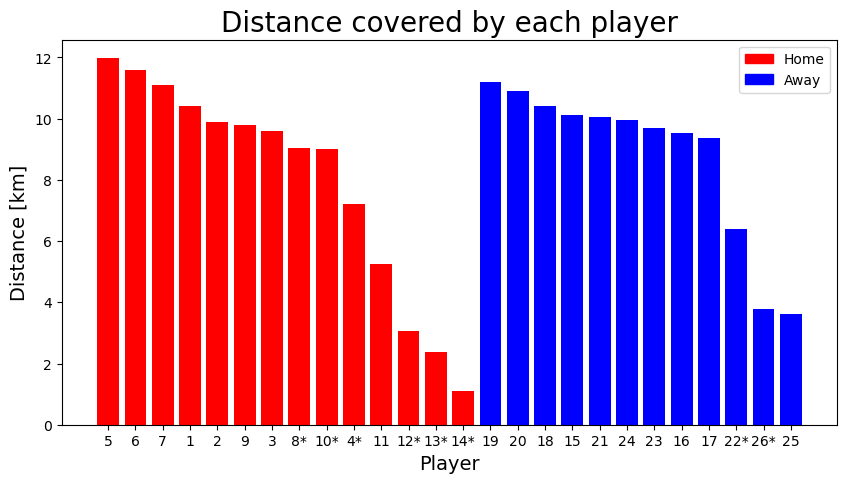

In [4]:
# Getting home players
home_players = np.unique(list(c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home'))
home_summary = pd.DataFrame(index=home_players)

# Calculating minutes played
minutes_home = []
for player in home_players:
    # Searching for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = (tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1) / 25 / 60. # convert to minutes
    minutes_home.append( player_minutes )
home_summary['Minutes Played'] = minutes_home
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

# Calculating distance covered
distance_home = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[
                          column].sum() / 25. / 1000  # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance_home.append(player_distance)
home_summary['Distance [km]'] = distance_home

# Getting away players
away_players = np.unique(list(c.split('_')[1] for c in tracking_away.columns if c[:4] == 'Away'))
away_summary = pd.DataFrame(index=away_players)

# Calculating minutes played
minutes_away = []
for player in away_players:
    # Searching for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Away_' + player + '_x' # use player x-position coordinate
    player_minutes = (tracking_away[column].last_valid_index() - tracking_away[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes_away.append( player_minutes )
away_summary['Minutes Played'] = minutes_away
away_summary = away_summary.sort_values(['Minutes Played'], ascending=False)

# Calculating distance covered
distance_away = []
for player in away_summary.index:
    column = 'Away_' + player + '_speed'
    player_distance = tracking_away[
                          column].sum() / 25. / 1000  # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance_away.append(player_distance)
away_summary['Distance [km]'] = distance_away

home_summary['Team'] = 'Home'
away_summary['Team'] = 'Away'

# Creating summary dataframe to make a plot
game_summary = pd.concat([home_summary, away_summary])
game_summary['isSub'] = np.where(game_summary['Minutes Played']== max(game_summary['Minutes Played']),0,1)
game_summary_sorted = game_summary.sort_values(['Team', 'Distance [km]'], ascending=[False, False])
game_summary_sorted['Player'] = game_summary_sorted.index
#star mean that player was subbed in or of
game_summary_sorted['Player'] = np.where(game_summary_sorted['isSub']==0, game_summary_sorted['Player'], game_summary_sorted['Player']+'*')

# Making plot
colors = ['red' for _ in range(len(home_summary))]
colors.extend(['blue' for _ in range(len(away_summary))])
color_map = {'Home':'red', 'Away':'blue'}
labels = list(color_map.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in labels]

plt.figure(figsize=(10,5))
plt.bar(game_summary_sorted['Player'], game_summary_sorted['Distance [km]'], color=colors)
plt.xlabel("Player", fontsize = 14)
plt.ylabel("Distance [km]", fontsize = 14)
plt.title("Distance covered by each player", fontsize = 20)
plt.legend(handles, labels)
plt.show()

### Calculating total distance covered by team players

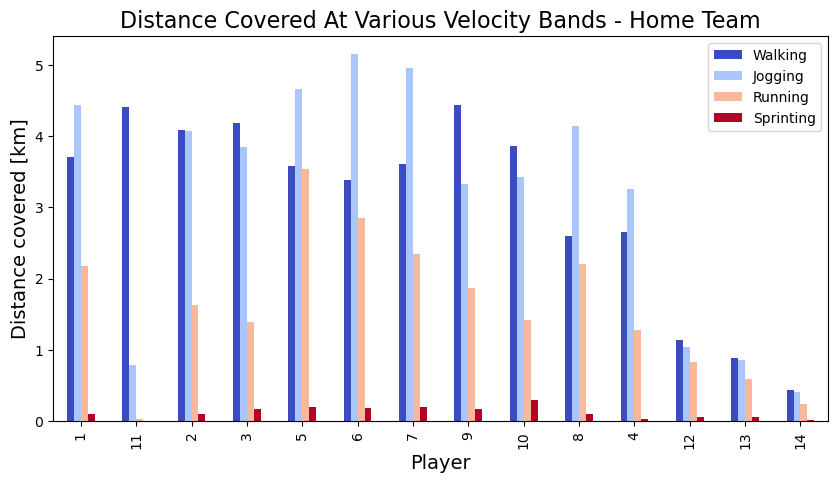

In [5]:
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum() / 25. / 1000
    walking.append(player_distance)
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[
                          (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum() / 25. / 1000
    jogging.append(player_distance)
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[
                          (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum() / 25. / 1000
    running.append(player_distance)
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[tracking_home[column] >= 7, column].sum() / 25. / 1000
    sprinting.append(player_distance)

home_summary['Walking'] = walking
home_summary['Jogging'] = jogging
home_summary['Running'] = running
home_summary['Sprinting'] = sprinting


ax = home_summary[['Walking','Jogging','Running','Sprinting']].plot.bar(colormap='coolwarm', figsize=(10, 5))
ax.set_xlabel('Player', fontsize = 14)
ax.set_ylabel('Distance covered [km]', fontsize = 14)
ax.set_title('Distance Covered At Various Velocity Bands - Home Team', fontsize = 16)
plt.show()

### Calculating acceleration/deceleration ratio

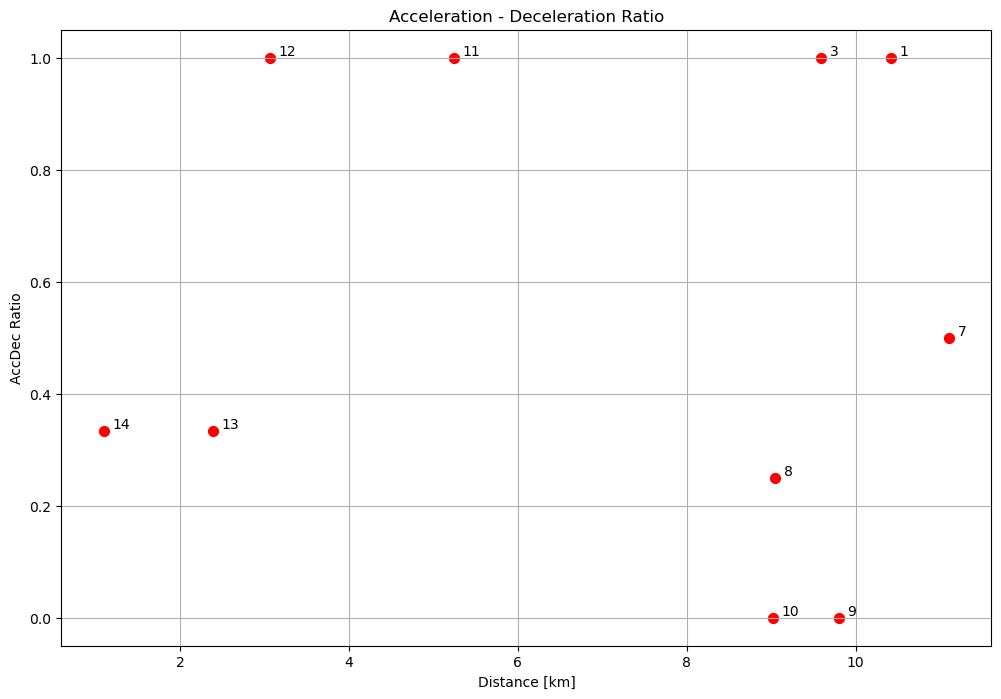

In [6]:
maxacc = 6
home_acc_dict = {}

for player in home_players:
    # Calculating acceleration

    tracking_home['Home_' + player + '_Acc'] = tracking_home['Home_' + player + '_speed'].diff() / dt
    
    # Setting acceleration condition
    tracking_home['Home_' + player + '_Acc'].loc[np.absolute(tracking_home['Home_' + player + '_Acc']) > maxacc] = np.nan
    
    # Checking if acceleration was high or low
    tracking_home['Home_' + player + '_Acc_type'] = np.where(np.absolute(tracking_home['Home_' + player + '_Acc']) >= 2,
                                                             "High", "Low")
    tracking_home['Home_' + player + '_Acc_g'] = tracking_home['Home_' + player + '_Acc_type'].ne(
        tracking_home['Home_' + player + '_Acc_type'].shift()).cumsum()

    #for each player
    for g in np.unique(tracking_home['Home_' + player + '_Acc_g']):
        acc_temp = tracking_home[tracking_home['Home_' + player + '_Acc_g'] == g]
        if acc_temp['Home_' + player + '_Acc_type'].iloc[0] == 'High':
            # Getting the acceleration period
            acc_duration = round(max(acc_temp['Time [s]']) - min(acc_temp['Time [s]']), 2)
            # Checking if it was acceleration or deceleration
            acc_or_dec = np.where(np.mean(acc_temp['Home_'+player+'_Acc']) > 0, "Acc", "Dec")
            # Creating a dictionary
            home_acc_dict[len(home_acc_dict) + 1] = {'Player': player, 'Group': g, 'Duration': acc_duration,
                                                     'Type': acc_or_dec}

home_acc_df = pd.DataFrame.from_dict(home_acc_dict,orient='index')

# Getting accelerations that were longer than 0.75 sec
home_acc_df1 = home_acc_df[home_acc_df['Duration']>=.75]

# Repeating for away team
away_acc_dict = {}
for player in away_players:
    tracking_away['Away_' + player + '_Acc'] = tracking_away['Away_' + player + '_speed'].diff() / dt
    tracking_away['Away_' + player + '_Acc'].loc[np.absolute(tracking_away['Away_' + player + '_Acc']) > maxacc] = np.nan
    tracking_away['Away_' + player + '_Acc_type'] = np.where(np.absolute(tracking_away['Away_' + player + '_Acc']) >= 2,
                                                             "High", "Low")
    tracking_away['Away_' + player + '_Acc_g'] = tracking_away['Away_' + player + '_Acc_type'].ne(
        tracking_away['Away_' + player + '_Acc_type'].shift()).cumsum()

    for g in np.unique(tracking_away['Away_' + player + '_Acc_g']):
        acc_temp = tracking_away[tracking_away['Away_' + player + '_Acc_g'] == g]
        if acc_temp['Away_' + player + '_Acc_type'].iloc[0] == 'High':
            acc_duration = round(max(acc_temp['Time [s]']) - min(acc_temp['Time [s]']), 2)
            acc_or_dec = np.where(np.mean(acc_temp['Away_'+player+'_Acc']) > 0, "Acc", "Dec")
            away_acc_dict[len(away_acc_dict) + 1] = {'Player': player, 'Group': g, 'Duration': acc_duration,
                                                     'Type': acc_or_dec}

away_acc_df = pd.DataFrame.from_dict(away_acc_dict,orient='index')
away_acc_df1 = away_acc_df[away_acc_df['Duration']>=.75]


# Calculating ratio for each player for the home team
accdec = []
for player in home_players:
    accs = home_acc_df1[(home_acc_df1['Player']==player) & (home_acc_df1['Type']=='Acc')].count()[0]
    decs = home_acc_df1[(home_acc_df1['Player']==player) & (home_acc_df1['Type']=='Dec')].count()[0]
    ac_ratio = accs / decs
    accdec.append(ac_ratio)

# Saving it in a dataframe
home_summary['AccDec'] = accdec

# Making a plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(home_summary['Distance [km]'], home_summary['AccDec'], color = "red", s = 50)
for i in home_summary.index:
    ax.annotate(str(i), (home_summary[home_summary.index==i]['Distance [km]']+ 0.1, home_summary[home_summary.index==i]['AccDec'] + 0.005), fontsize = 10)
ax.set_xlabel("Distance [km]")
ax.set_ylabel("AccDec Ratio")
plt.grid()
plt.title("Acceleration - Deceleration Ratio")
plt.show()

### Calculating metabolic power

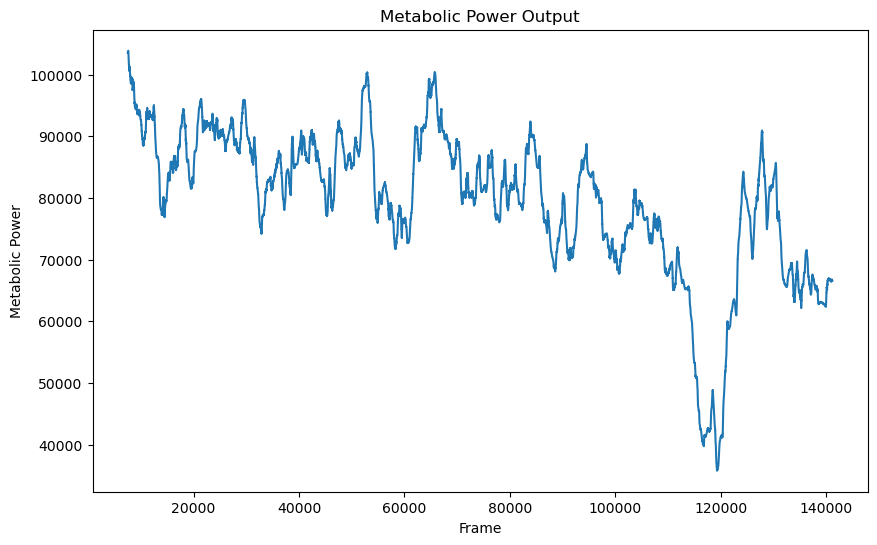

In [7]:
def split_at(s, c, n):
    words = s.split(c)
    return c.join(words[:n]), c.join(words[n:])

#function to calculate metabolic cost
def metabolic_cost(acc): #https://jeb.biologists.org/content/221/15/jeb182303
    if acc > 0:
        cost = 0.102 * ((acc ** 2 + 96.2) ** 0.5) * (4.03 * acc + 3.6 * np.exp(-0.408 * acc))
    elif acc < 0:
        cost = 0.102 * ((acc ** 2 + 96.2) ** 0.5) * (-0.85 * acc + 3.6 * np.exp(1.33 * acc))
    else:
        cost = 0
    return cost

team = tracking_home

playerids = np.unique(list(c[:-2] for c in team.columns if c[:4] in ['Home', 'Away']))
playerids = np.unique(list(map(lambda x: split_at(x, '_', 2)[0], playerids)))

fig, ax = plt.subplots(figsize = (10, 6))
player = 'Home_6'

# Calculating metabolic cost
mc_temp = list(map(lambda x: metabolic_cost(team[player + '_Acc'][x]), range(1, len(team[player + '_Acc'])+1)))

# Multiplying it by speed
mp_temp = mc_temp * team[player+'_speed']

# Calculating rolling average
test_mp = mp_temp.rolling(7500,min_periods=1).apply(lambda x : np.nansum(x)) #Use Changepoint Detection Here
ax.plot(test_mp[7500:])
ax.set_title('Metabolic Power Output')
ax.set_ylabel("Metabolic Power")
ax.set_xlabel("Frame")
plt.show()

### Change point detection

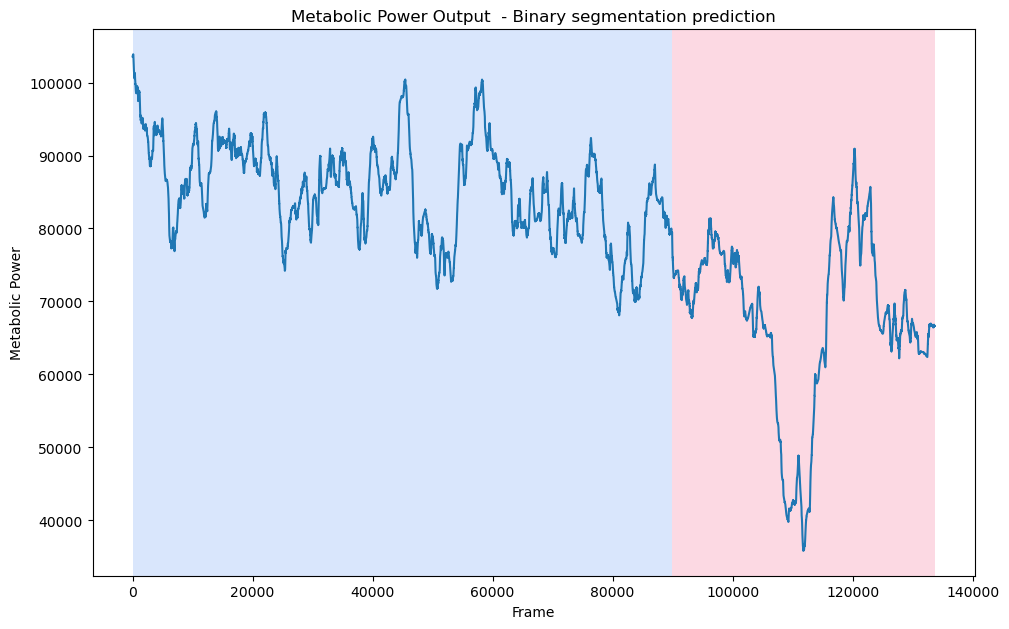

In [8]:
signal = np.array(test_mp[7500:len(test_mp)]).reshape((len(test_mp[7500:len(test_mp)]),1))
algo = rpt.Binseg(model="l2").fit(signal)  ##potentially finding spot where substitution should happen
result = algo.predict(n_bkps=1)  # big_seg
rpt.show.display(signal, result, figsize=(10, 6))
plt.title('Metabolic Power Output  - Binary segmentation prediction')
plt.ylabel("Metabolic Power")
plt.xlabel("Frame")
plt.show()

### Multiple changing points

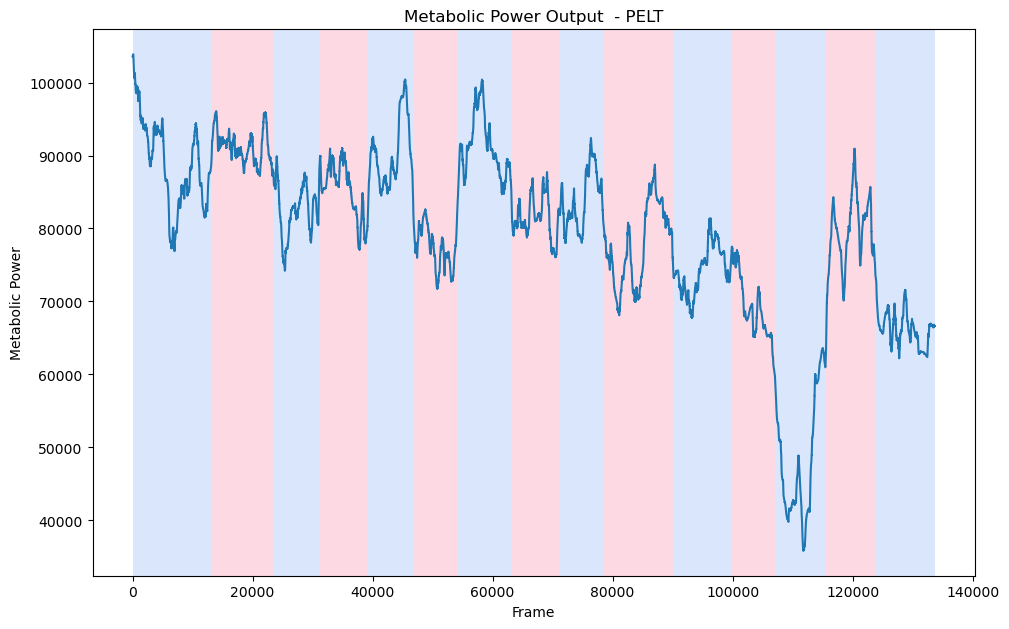

In [9]:
signal = np.array(test_mp[7500:len(test_mp)]).reshape((len(test_mp[7500:len(test_mp)]),1))
algo = rpt.Pelt(model="l2",min_size=7500).fit(signal)
result = algo.predict(pen=np.log(len(signal))*1*np.std(signal)**2)
rpt.show.display(signal, result, figsize=(10, 6))
plt.title('Metabolic Power Output  - PELT')
plt.ylabel("Metabolic Power")
plt.xlabel("Frame")
plt.show()